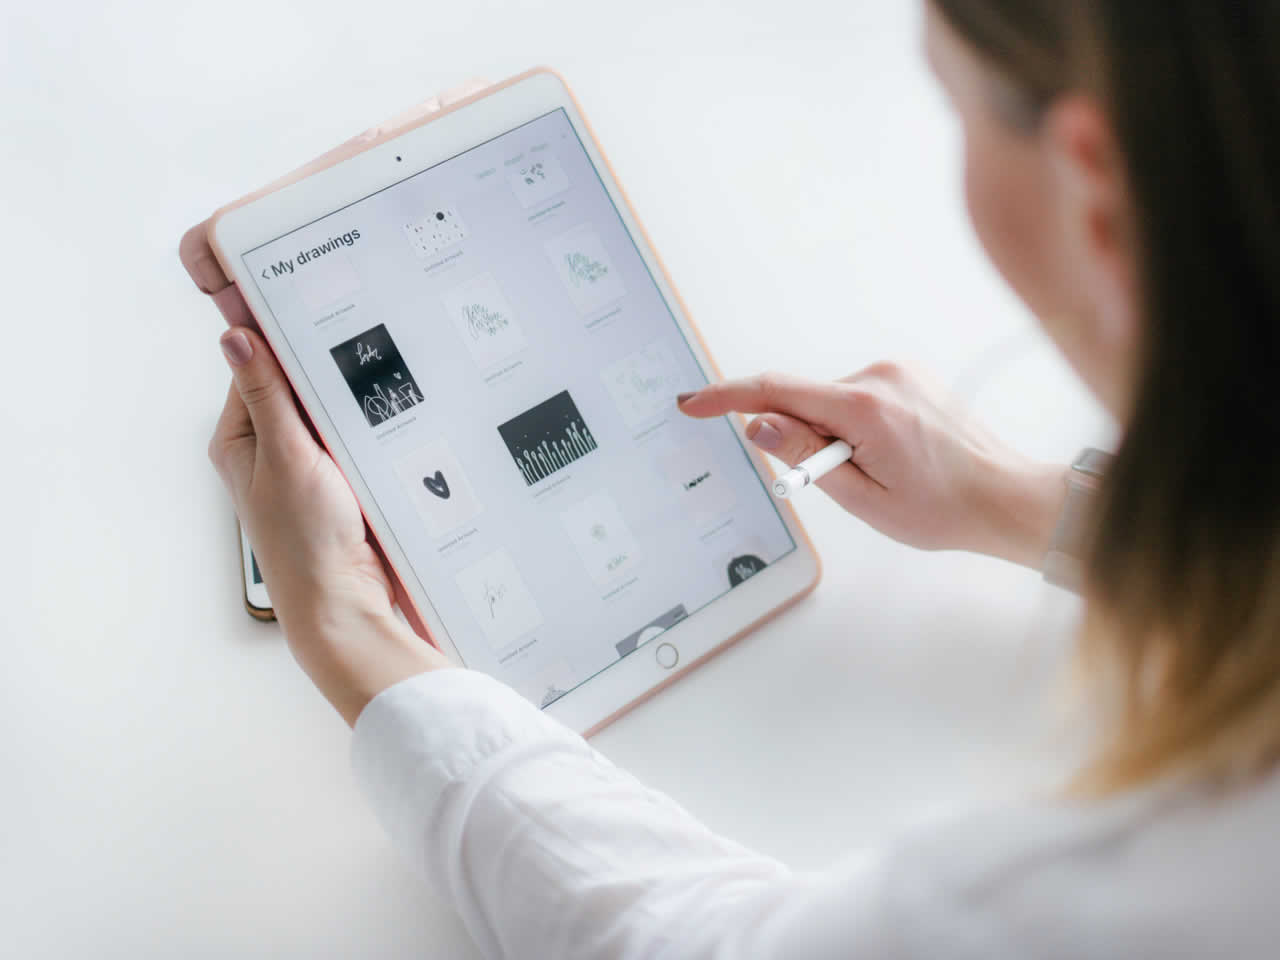

In [78]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')
from IPython import display
display.Image("work-8.jpg")

### Importing Data Files

In [42]:
#Import Product DataSet here
product_data = pd.read_csv('Product Data Set.csv',sep='|')
product_data.head()

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [43]:
#Import Transaction DataSet Here
transactions_data = pd.read_csv('Transaction Data Set.csv',sep='|')
transactions_data.head()

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [44]:
#Import Customer Dataset Here
customer_data=pd.read_csv('Customer Data Set.csv')
customer_data.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


-------------------------------------------

### Changing Data Types

In [45]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

-----------------------------------------------------

### Creating Customer View

In [47]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})
customer_prod_categ=customer_prod_categ.reset_index()
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )
customer_KPIs=customer_KPIs.fillna(0)

customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)
customer_all_view.head()

------------------------

# Linear Regression 
### Feed the following variables to the linear regression model to predict the total spending of the customers.

In [58]:
DF_input=customer_all_view[['GENDER','AGE','INCOME','EXPERIENCE SCORE','LOYALTY GROUP','HOUSEHOLD SIZE','MARITAL STATUS']]
DF_input.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS
0,0,64,133498,5,enrolled,4,Single
1,0,42,94475,9,notenrolled,6,Married
2,0,40,88610,9,enrolled,5,Married
3,0,38,84313,8,enrolled,1,Single
4,0,30,51498,3,notenrolled,1,Single


### Next we create four columns that are named Single, Married, Divorced, and Widow/Widower. We then use <code>pd.get_dummies</code> so that we can actually use this data in our regression model.

In [59]:
DF_input["MARITAL STATUS"].unique()
pd.get_dummies(DF_input["MARITAL STATUS"]).head(10)

,Divorced,Married,Single,Widow/Widower
0,0,0,1,0
1,0,1,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0
5,0,1,0,0
6,0,1,0,0
7,0,0,1,0
8,0,1,0,0
9,0,1,0,0


### We utlise a binary encoder function on the loyalty variable to get an idea if the customer is enrolled in the "rewards" programme and <code>apply</code> it to the "LOYALTY GROUP" column in the dataframe.

In [60]:
def encode_loyalty(value):
    if value == "enrolled" :
        return 1 
    else : 
        return 0

In [79]:
#Apply this function to the “loyalty group” column
DF_input['LOYALTY GROUP']=DF_input['LOYALTY GROUP'].apply(encode_loyalty)
DF_input.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,0,64,133498,5,0,4,0,0,1,0
1,0,42,94475,9,0,6,0,1,0,0
2,0,40,88610,9,0,5,0,1,0,0
3,0,38,84313,8,0,1,0,0,1,0
4,0,30,51498,3,0,1,0,0,1,0


In [62]:
#replace the “DF_input” frame with the one-hot encoded Pandas data frame
DF_input=pd.get_dummies(DF_input)
DF_input.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,0,64,133498,5,1,4,0,0,1,0
1,0,42,94475,9,0,6,0,1,0,0
2,0,40,88610,9,1,5,0,1,0,0
3,0,38,84313,8,1,1,0,0,1,0
4,0,30,51498,3,0,1,0,0,1,0


### We need to re-create the Pandas data frame for the NumPy format.

In [63]:
DF_input_column_names = DF_input.columns.values
DF_input_np=preprocessing.minmax_scale(DF_input)
Reg_input_scaled=pd.DataFrame(DF_input_np, columns=DF_input_column_names)
Reg_input_scaled=pd.DataFrame(DF_input_np, columns=DF_input_column_names)
Reg_input_scaled.head()

,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,0.0,0.638889,0.872818,0.444444,1.0,0.6,0.0,0.0,1.0,0.0
1,0.0,0.333333,0.572046,0.888889,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.305556,0.526842,0.888889,1.0,0.8,0.0,1.0,0.0,0.0
3,0.0,0.277778,0.493722,0.777778,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.166667,0.240799,0.222222,0.0,0.0,0.0,0.0,1.0,0.0


### We need to create a train-test split with the data from the <code>Reg_input_scaled</code> and start training the model on the training data set.

In [64]:
#Create a train – test split of 80% training and 20% testing
X_train,X_test,Y_train,Y_test = train_test_split(Reg_input_scaled,customer_all_view['TOTAL SPENT'], test_size=0.2,random_state=42)
#Train the model on the training data set
regr = LinearRegression()
regr.fit(X_train, Y_train)

In [66]:
#predict the values of total spending for the testing feature and find coefficients
Y_pred = regr.predict(X_test)
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [   35.58494877 -7076.18001534 12403.0952701    505.84578936
  1566.48092344  1040.19923196   377.33573376   -82.02665324
   -34.57620088  -260.73287964]


In [67]:
#order of coefficients
Reg_input_scaled.columns.values

array(['GENDER', 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'LOYALTY GROUP',
       'HOUSEHOLD SIZE', 'MARITAL STATUS_Divorced',
       'MARITAL STATUS_Married', 'MARITAL STATUS_Single',
       'MARITAL STATUS_Widow/Widower'], dtype=object)

In [68]:
#Obtain the intercept
print('intercept: \n', regr.intercept_)

intercept: 
 -38.169475218648586


In [69]:
#Evaluate the performance of the linear model by calculating the mean squared error.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred)) 

Mean squared error: 3164098.64


In [77]:
#Get the Mean Error
print('The Mean Error is = ', math.sqrt(mean_squared_error(Y_test, Y_pred)))
print("Which means that there is an error of : $", math.sqrt(mean_squared_error(Y_test, Y_pred)) )

The Mean Error is =  1778.7913411697502


AttributeError: module 'math' has no attribute 'rnd'

------------------------------------------------------